# Shortest path data generator

Generate trajectories from (1,1) to (10,10) with shortest path. 
Generate total_trajectories number of trajectories and save the trajectories into data.txt.
Each location is mapped to a unique number (x-1)*may(y)+y and the mapping is saved to codebook.txt

## 1. Generate trajectories for training

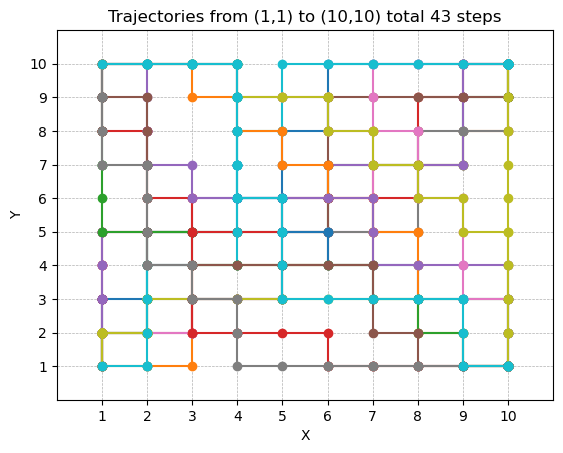

In [1]:
# random simulation time
simulation_num = 60
# Define the grid size
grid_size = 10
# Define the total number of trajectories
total_trajectories = 20
# trajectory training data option: 
# 0: from (1,1) to (10,10) * 100 trajectories
# 1: from (1,1) to (10,10) * 50 trajectories, from (1,10) to (10,1) * 50 trajectories
trajectory_option = 1

import numpy as np
import matplotlib.pyplot as plt
import copy

# trajectory：[[x_0,y_0,s_0,d_x,d_y],[x_1,y_1,s_1],...], s means the stay time left on current point
# direction : [d_x, d_y], means the moving direction

# generate_trajectory(): generate evary trajector
# update_position(): if stay=0, move to next point, update the grid capacity (car number on each point)
# update_stay(): if chek if the new trajectory has to stay for stay_time


def update_postion(current_point, end_point, grid_capacity, direction = [1,1], grid_size=10):
    # trajectory: [T-1,3]
    # current_point = trajectory[-1]
    # grid_capacity: [grid_size,grid_size]

    if current_point[0]==end_point[0] and current_point[1]==end_point[1]:
        #already finish
        next_point = copy.deepcopy(current_point)

    elif current_point[2] >0:
        # stay at this point and stay time -1
        next_point = copy.deepcopy(current_point)
        next_point[2] -= 1

    elif current_point[0]+direction[0] < 1 or current_point[0]+direction[0] > grid_size:
        # x is on boundary, move y
        next_point = copy.deepcopy(current_point)
        next_point[1] += direction[1]

    elif current_point[1]+direction[1] < 1 or current_point[1]+direction[1] > grid_size:
        # y is on boundary, move x
        next_point = copy.deepcopy(current_point)
        next_point[0] += direction[0]
    else:
        # point inside, move randomly
        if np.random.rand() <0.5:
            next_point = copy.deepcopy(current_point)
            next_point[1] += direction[1]
        else:
            next_point = copy.deepcopy(current_point)
            next_point[0] += direction[0]

    # trajectory.append(next_point)
    grid_capacity[current_point[0]-1,current_point[1]-1] -=1
    grid_capacity[next_point[0]-1,next_point[1]-1] +=1


    return next_point, grid_capacity


def update_stay(former_point, current_point, grid_capacity):
    # trajectory: [T,3]
    # former_point = trajectory[-2]
    # current_point = trajectory[-1]

    if former_point[2] ==0 and current_point[2]==0: # didn't stay, or stayed until stay=0 and moved to current point
        current_point[2] = grid_capacity[current_point[0]-1,current_point[1]-1]-1 # 1 car means no stay time, 2 car means stay for 1 time,...
    return current_point


def initialize_start(grid_size=10, trajectory_option = 0,trajectory_num = 10):
    # define start points, directions and grid_capacity

    start_points = np.zeros([trajectory_num,2],dtype= int)
    end_points = np.zeros([trajectory_num,2],dtype= int)
    directions = np.zeros([trajectory_num,2],dtype= int)
    grid_capacity = np.zeros([grid_size,grid_size],dtype= int)
    end_capacity = np.zeros([grid_size,grid_size],dtype= int)

    if trajectory_option == 0:
        start_points[:,0] = 1
        start_points[:,1] = 1
        end_points[:,0] = 10
        end_points[:,1] = 10
        directions[:,0] = 1
        directions[:,1] = 1
        grid_capacity[0,0] = trajectory_num
        end_capacity[grid_size-1,grid_size-1] = trajectory_num

    elif trajectory_option == 1:
        start_points[:trajectory_num//2,0] = 1
        start_points[trajectory_num//2:,0] = 1
        start_points[:trajectory_num//2,1] = 1
        start_points[trajectory_num//2:,1] = grid_size
        end_points[:trajectory_num//2,0] = grid_size
        end_points[trajectory_num//2:,0] = grid_size
        end_points[:trajectory_num//2,1] = grid_size
        end_points[trajectory_num//2:,1] = 1
        directions[:trajectory_num//2,0] = 1
        directions[trajectory_num//2:,0] = 1
        directions[:trajectory_num//2,1] = 1
        directions[trajectory_num//2:,1] = -1
        grid_capacity[0,0] = trajectory_num//2
        grid_capacity[0,grid_size-1] = trajectory_num - trajectory_num//2
        end_capacity[grid_size-1,grid_size-1] = trajectory_num//2
        end_capacity[grid_size-1,0] = trajectory_num - trajectory_num//2

    return start_points, end_points, directions, grid_capacity, end_capacity


def generate_trajectory_list(grid_size=10, trajectory_option = 0,trajectory_num = 10):

    start_points, end_points, directions, grid_capacity, end_capacity = initialize_start(grid_size, trajectory_option,trajectory_num)

    # initialize cars
    trajectory_list = []
    # trajectory_list = [trajectory1, trajectory2,...], trajectory1 = [state_1,state2,...], state_1 = [x,y,s]
    for i in range(trajectory_num):
        trajectory_list.append([[start_points[i,0],start_points[i,1],0]])
    
    while not (grid_capacity==end_capacity).all(): # not all cars get to the end points
        # move
        for i in range(trajectory_num):
            current_point = trajectory_list[i][-1]
            direction = directions[i]
            end_point = end_points[i]
            next_point, grid_capacity = update_postion(current_point, end_point, grid_capacity, direction, grid_size)
            trajectory_list[i].append(next_point)
        # update stay
        for i in range(trajectory_num):
            former_point = trajectory_list[i][-2]
            current_point = trajectory_list[i][-1]
            current_point = update_stay(former_point, current_point, grid_capacity)
            trajectory_list[i][-1] = current_point

    return trajectory_list

# Generate the codebook
codebook = {}
max_value = grid_size  # max(y) = 10 in this case

# Populate the codebook with grid cells
for x in range(1, grid_size + 1):
    for y in range(1, grid_size + 1):
        code = (x - 1) * max_value + y
        codebook[(x, y)] = str(code)

# Save the codebook to a file
with open('./data/codebook.txt', 'w') as file:
    for key, value in codebook.items():
        file.write(f'{key}: {value}\n')

#simulation for 10 times
for t in range(simulation_num):
    # Generate and save 10 trajectories
    all_encoded_trajectories = []
    trajectory_list = generate_trajectory_list(grid_size, trajectory_option, total_trajectories)

    for i in range(total_trajectories):
        trajectory = trajectory_list[i]
        encoded_trajectory = [codebook[(x, y)] for x, y, s in trajectory]
        # # Append '0' at the end of each trajectory
        # encoded_trajectory.append('0')
        all_encoded_trajectories.append(encoded_trajectory)


    # Save all trajectories to a single file
    with open(f'./data/simulation_{t}.txt', 'w') as file:
        # file.write(' '.join(all_encoded_trajectories))
        for trajectory in all_encoded_trajectories:
            file.write(' '.join(trajectory))
            file.write('\n')

# Plotting the trajectory
for i in range(total_trajectories):
    trajectory_x, trajectory_y,trajectory_s = zip(*trajectory_list[i])
    plt.plot(trajectory_x, trajectory_y, marker='o', label=f'Trajectory {i+1}')

# Plot configuration
plt.xlim(0, grid_size + 1)
plt.ylim(0, grid_size + 1)
plt.xticks(np.arange(1, grid_size + 1, 1))
plt.yticks(np.arange(1, grid_size + 1, 1))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Trajectories from (1,1) to (10,10) total {len(trajectory_x)} steps')
plt.show()


## 3. Models

In [79]:
# Part 1. Define Functions
import torch
import torch.nn as nn
from torch.nn import functional as F

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, n_embd, head_size, block_size, dropout):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,N,C = x.shape
        k = self.key(x)   # (B,T,N,C)
        q = self.query(x) # (B,T,N,C)
        # compute time attention
        wei_T = q.permute(0,2,1,3) @ k.permute(0,2,3,1) # (B,N,T,C) @ (B,N,C,T) -> (B,N,T,T)
        wei_T = wei_T / (C ** 0.5)
        wei_T = F.softmax(wei_T, dim=-1)
        # compute spatial attention
        wei_N = q @ k.permute(0,1,3,2) # (B,T,N,C) @ (B,T,N,C) -> (B,T,N,N)
        wei_N = wei_N / (C ** 0.5)
        wei_N = F.softmax(wei_N, dim=-1)

        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,N,C)
        out = wei_T @ v.permute(0,2,1,3) # (B,N,T,T) @ (B,N,T,C) -> (B,N,T,C)
        out = out.permute(0,2,1,3) # (B,T,N,C)
        out = wei_N @ out # (B,T,N,N) @ (B,T,N,C) -> (B,T,N,C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, n_head, head_size, n_embd, block_size, dropout):
        super().__init__()
        self.heads = nn.ModuleList([Head(n_embd, head_size, block_size, dropout) for _ in range(n_head)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head, block_size, dropout):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size, n_embd, block_size, dropout)
        self.ffwd = FeedFoward(n_embd, dropout)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size, n_embd, n_layer, n_head, block_size, dropout):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.block_size = block_size
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        # for attention
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head, block_size, dropout) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T, N = idx.shape # 8, 50, 100
        device = idx.device

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,N,C)
        pos_emb = self.position_embedding_table(torch.arange(T).to(device)) # (T,C)
        pos_emb = pos_emb.unsqueeze(0) # (1,T,C)
        pos_emb = pos_emb.expand(N, -1, -1) # (N,T,C)
        pos_emb = pos_emb.permute(1, 0, 2) # (T,N,C)
        x = tok_emb + pos_emb # (B,T,N,C)
        x = self.blocks(x) # (B,T,N,C)
        x = self.ln_f(x) # (B,T,N,C)
        logits = self.lm_head(x) # (B,T,N,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, N, C = logits.shape
            logits = logits.view(B*T*N, C)
            targets = targets.view(B*T*N)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T, N) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -self.block_size:, :]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :, :] # becomes (B, N, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, N, C)
            # sample from the distribution 
            idx_next = torch.zeros([probs.shape[0], 1, probs.shape[1]]).to(probs.device) # (B,1, N)
            for n in range(probs.shape[1]):
                idx_next[:,0,n] = torch.multinomial(probs[:,n,:], num_samples=1).squeeze(1) # (B, N, 1)
            # idx_next = torch.multinomial(probs, num_samples=1) # (B, N, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next.type_as(idx)), dim=1) # (B, T+1, N)
        return idx


class BigramLanguageModelWithoutAttention(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx) # (B,T,C)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            # pytorch takes B, C, T
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx


## 3. Train the model

In [80]:

# HERE SELECTING WHETHER TO USE ATTENTION
use_attention = True
# Interations for training model
max_iters = 5000

# hyperparameters
batch_size = 8 # how many independent sequences will we process in parallel?
block_size = 10 # what is the maximum context length for predictions?
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 8
dropout = 0.0
# ------------


# Function to read the encoded data from a file and save it as a list of integers
def read_encoded_data(filename):
    data = []
    with open(filename, 'r') as file:
        for line in file:
            trajectory = line.strip().split()
            trajectory = [int(code) for code in trajectory]
            data.append(trajectory)
    # data: NxT
    data = torch.tensor(data)
    # transpose data to T x N
    data = data.t()
    # n = int(0.9*len(data)) # first 90% will be train, rest val
    # train_data = data[:n]
    # val_data = data[n:]
    # return train_data, val_data
    return data

def generate_new_data(grid_size=10, trajectory_option = 0,trajectory_num = 10):
    trajectory_list = generate_trajectory_list(grid_size, trajectory_option,trajectory_num) # N T 3
    data = []
    for i in range(trajectory_num):
        trajectory = trajectory_list[i]
        encoded_trajectory = [int(codebook[(x, y)]) for x, y, s in trajectory]
        data.append(encoded_trajectory)
    data = torch.tensor(data)
    data = data.t()
    return data

    
# data loading
def get_batch(data_list, block_size, batch_size):
    # generate a small batch of data of inputs x and targets y
    x = []
    y = []
    for i in range(batch_size):
        data = data_list[torch.randint(len(data_list),(1,))]
        start_index = torch.randint(len(data) - block_size, (1,))
        x.append(data[start_index:start_index+block_size])
        y.append(data[start_index+1:start_index+block_size+1])
    x = torch.stack(x)
    y = torch.stack(y)
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss(model, train_data_list, valid_data_list, block_size, batch_size, eval_iters=200):
    out = {}
    model.eval()
    losses = torch.zeros(eval_iters)
    for k in range(eval_iters):
        X, Y = get_batch(train_data_list,block_size, batch_size)
        logits, loss = model(X, Y)
        losses[k] = loss.item()
    out['train'] = losses.mean()
    losses = torch.zeros(eval_iters)
    if valid_data_list is not None:
        for k in range(eval_iters):
            X, Y = get_batch(valid_data_list,block_size, batch_size)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out['val'] = losses.mean()
    model.train()
    return out

# torch.manual_seed(1337)

train_data_list = []
valid_data_list = []
for i in range(simulation_num):
    train_data = read_encoded_data(f'./data/simulation_{i}.txt')
    train_data = train_data.to(device)
    train_data = train_data -1 # 0-indexing
    train_data_list.append(train_data)
valid_data = generate_new_data(grid_size, trajectory_option, total_trajectories)
valid_data = valid_data.to(device)
valid_data = valid_data -1 # 0-indexing
valid_data_list.append(valid_data)

# Count the number of unique integers
unique_integers = set(train_data.flatten().tolist())
# embedding table is vocab*vocab, every integer needs to map to a row in the embedding table
vocab_size = max(unique_integers)+1 # 1-indexing, 0-99 -> 1-100



if use_attention:
    model = BigramLanguageModel(vocab_size, n_embd, n_layer, n_head, block_size, dropout)
else:    
    model = BigramLanguageModelWithoutAttention(vocab_size)

    
model = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):
    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss(model, train_data_list, valid_data_list, block_size, batch_size, eval_iters=eval_iters)
        if valid_data_list is not None:
            print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        else:
            print(f"step {iter}: train loss {losses['train']:.4f}")

    # sample a batch of data
    xb, yb = get_batch(train_data_list, block_size, batch_size)

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

0.412004 M parameters
step 0: train loss 4.7736, val loss 4.7612
step 100: train loss 1.1713, val loss 1.2460
step 200: train loss 0.9365, val loss 0.9801
step 300: train loss 0.8060, val loss 0.8725
step 400: train loss 0.6590, val loss 0.7740
step 500: train loss 0.4907, val loss 0.6332
step 600: train loss 0.3356, val loss 0.4492
step 700: train loss 0.2402, val loss 0.3072
step 800: train loss 0.2089, val loss 0.2693
step 900: train loss 0.1913, val loss 0.2466
step 1000: train loss 0.1784, val loss 0.2266
step 1100: train loss 0.1807, val loss 0.2285
step 1200: train loss 0.1699, val loss 0.2132
step 1300: train loss 0.1720, val loss 0.2149
step 1400: train loss 0.1655, val loss 0.2189
step 1500: train loss 0.1656, val loss 0.2183
step 1600: train loss 0.1644, val loss 0.2117
step 1700: train loss 0.1582, val loss 0.2086
step 1800: train loss 0.1599, val loss 0.2238
step 1900: train loss 0.1492, val loss 0.2086
step 2000: train loss 0.1601, val loss 0.2119
step 2100: train loss 0.

## 4. Generate the trajectory from the model

In [81]:
# context = torch.zeros((1, 1, total_trajectories),dtype = int, device=device) # B T N
# context = train_data[:block_size].unsqueeze(0) # 1 T N
context = valid_data[:block_size].unsqueeze(0) # 1 T N
generated_traj = model.generate(context, max_new_tokens=60)[0] #T N, 160 100
generated_traj = generated_traj.t().tolist() # N T, 100 160


# Function to read the codebook from a file
def read_codebook(filename):
    codebook = {}
    with open(filename, 'r') as file:
        for line in file:
            parts = line.strip().split(': ', 1)  # Split at the first colon
            key = eval(parts[0])  # Evaluate the key part
            value = parts[1]  # Use the value part
            codebook[int(value)] = key
    return codebook

# Function to decode the data from a file using the codebook
def decode_data(generated_traj, codebook):
    decoded_trajectories = []
    for trajectory in generated_traj:
        trajectory = [codebook[code+1] for code in trajectory]
        decoded_trajectories.append(trajectory)
            
    return decoded_trajectories

def check_stay(decoded_trajectories, end_points):
    # trajectory: [N,T,2]
    # check if the trajectory follows the stay rule
    check_result = np.ones([len(decoded_trajectories),len(decoded_trajectories[0])],dtype = int) # [N, T]
    stay_time = np.zeros([total_trajectories],dtype= int) # former, current stay time
    for i in range(1,len(decoded_trajectories[0])): # [1:T-1]
        grid_capacity = np.zeros([grid_size,grid_size],dtype= int)
        for j in range(len(decoded_trajectories)): # N
            grid_capacity[decoded_trajectories[j][i][0]-1,decoded_trajectories[j][i][1]-1] +=1
        for j in range(len(decoded_trajectories)):
            if decoded_trajectories[j][i] == end_points[j]: # already finished
                continue
            if decoded_trajectories[j][i] == decoded_trajectories[j][i-1]: # didn't move
                if stay_time[j] == 0: # should move but didn't
                    check_result[j,i] = 0
                else: # shouldn't move and didn't
                    stay_time[j] -=1
            else: # moved
                if stay_time[j] == 0: # should move and moved, new stay time
                    stay_time[j] = grid_capacity[decoded_trajectories[j][i][0]-1,decoded_trajectories[j][i][1]-1]-1
                else: # shouldn't move but moved
                    check_result[j,i] = 0
                    stay_time[j] = grid_capacity[decoded_trajectories[j][i][0]-1,decoded_trajectories[j][i][1]-1]-1
    return check_result # N T


# Read the codebook
codebook = read_codebook('./data/codebook.txt')

# Decode the data
# print(len(generated_traj))
# for trajectory in generated_traj:
#     print(trajectory)
decoded_trajectories = decode_data(generated_traj, codebook)
end_points = []
for i in range(total_trajectories):
    end_points.append(decoded_trajectories[i][-1])
check_result = check_stay(decoded_trajectories, end_points)

# Print the decoded trajectories
for i, trajectory in enumerate(decoded_trajectories):
    RED = '\033[31m'
    GREEN = '\033[32m'
    RESET = '\033[0m'  # 用于重置颜色，以免影响后续文本
    text = f'Trajectory {i+1}:'
    text += f'Total stay time: {len(trajectory)+1}, Wrong stay time: {len(trajectory)+1-np.sum(check_result[i])}: '
    for j, point in enumerate(trajectory):
        if check_result[i,j] == 1:
            text += f'{RESET} {point}'
        else:
            text += f'{RED} {point}'
    print(text)


Trajectory 1:Total stay time: 71, Wrong stay time: 1:  (1, 1) (2, 1) (2, 1) (2, 1) (2, 1) (2, 1) (3, 1) (3, 1) (3, 1) (3, 1) (3, 2) (3, 3) (4, 3) (5, 3) (6, 3) (7, 3) (8, 3) (9, 3) (10, 3) (10, 2) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1)
Trajectory 2:Total stay time: 71, Wrong stay time: 8:  (1, 1) (2, 1) (2, 1) (2, 1) (2, 1) (2, 1) (3, 1) (3, 1) (3, 1) (3, 1) (3, 1) (4, 1) (4, 1) (4, 1) (5, 1) (6, 1) (7, 1) (7, 1) (7, 1) (8, 1) (9, 1) (9, 1) (9, 1) (9, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10, 1) (10,

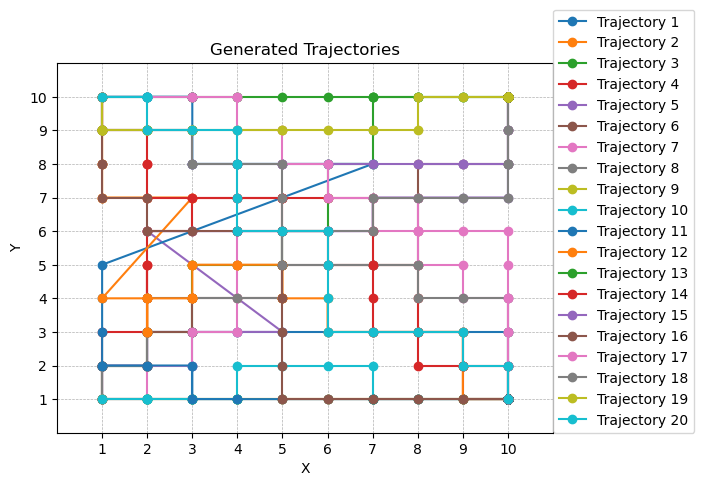

In [82]:
import matplotlib.pyplot as plt
import numpy as np
import random

def truncate_trajectory(decoded_trajectories, end_index_list):
    for i in range(len(decoded_trajectories)):
        for j in range(len(decoded_trajectories[i])):
            if decoded_trajectories[i][j] == end_index_list[i]:
                decoded_trajectories[i] = decoded_trajectories[i][:j+1]
                break
    return decoded_trajectories
    

def plot_trajectories(decoded_trajectories, trajectory_index=None):
 #   plt.figure(figsize=(8, 8))

    # Plot configuration
    grid_size = 10
    plt.xlim(0, grid_size + 1)
    plt.ylim(0, grid_size + 1)
    plt.xticks(np.arange(1, grid_size + 1, 1))
    plt.yticks(np.arange(1, grid_size + 1, 1))
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Generated Trajectories')

    # Plot the specified trajectory or all trajectories
    if trajectory_index is not None:
        trajectory = decoded_trajectories[trajectory_index]
        x = [point[0] for point in trajectory]
        y = [point[1] for point in trajectory]
        plt.plot(x, y, marker='o', label=f'Trajectory {trajectory_index + 1}')
    else:
        for i, trajectory in enumerate(decoded_trajectories):
            x = [point[0] for point in trajectory]
            y = [point[1] for point in trajectory]
            plt.plot(x, y, marker='o', label=f'Trajectory {i+1}')

    num1 = 1
    num2 = 0
    num3 = 3
    num4 = 0
    plt.legend(bbox_to_anchor=(num1, num2), loc=num3, borderaxespad=num4)
    plt.show()


trajectory_index = -1
end_index_list = train_data[-1, :].tolist() # T N -> N
end_index_list = [codebook[code+1] for code in end_index_list]
decoded_trajectories =  truncate_trajectory(decoded_trajectories, end_index_list)

if trajectory_index == -1:
    # Plot all trajectories
    plot_trajectories(decoded_trajectories)
else:
    #trajectory_index = random.randint(0, len(decoded_trajectories) - 1)
    # Plot a specific trajectory (e.g., the first trajectory, index 0)
    plot_trajectories(decoded_trajectories, trajectory_index)
